# Import Libariers and Dataset Loading

In [1]:
!pip install --upgrade supervision
!pip install ultralytics
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon
import supervision as sv
import random
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm
import yaml
import cv2
from ultralytics import YOLO
import time 
from shapely.geometry import box

images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'
labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 16.2 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Exploration and Understanding

#### 1. Dataset statistics 


In [2]:
import os
import glob
import shutil

src_labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
dst_labels_path = '/kaggle/working/srip_labels/labels_native/'

os.makedirs(dst_labels_path, exist_ok=True)
src_label_files = glob.glob(os.path.join(src_labels_path, '*.txt'))
for file in src_label_files:
    shutil.copy(file, dst_labels_path)
    
print(f"Copied {len(src_label_files)} label files to {dst_labels_path}")
label_files = glob.glob(os.path.join(dst_labels_path, '*.txt'))

total_instances = 0
class_count = {}

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            cls = line.split()[0]
            class_count[cls] = class_count.get(cls, 0) + 1

class_count = dict(sorted(class_count.items()))
print("Initial Distribution:")
print(f"Total instances: {total_instances}")
print(f"Number of unique classes: {len(class_count)}")
print("Class-wise distribution:")
for cls, count in class_count.items():
    print(f"    Class {cls}: {count}")

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    unique_lines = set()
    new_lines = []
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        
        if parts[0] in ['1', '2']:
            parts[0] = '0'
        
        new_line = ' '.join(parts)
        
        if new_line not in unique_lines:
            unique_lines.add(new_line)
            new_lines.append(new_line)
    
    with open(label_file, 'w') as f:
        for line in new_lines:
            f.write(line + "\n")

new_class_count = {}
updated_total_instances = 0

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        updated_total_instances += len(lines)
        for line in lines:
            cls = line.split()[0]
            new_class_count[cls] = new_class_count.get(cls, 0) + 1

new_class_count = dict(sorted(new_class_count.items()))
print("\nUpdated class-wise distribution:")
for cls, count in new_class_count.items():
    print(f"    Class {cls}: {count}")
print(f"\nTotal updated instances: {updated_total_instances}")

Copied 2542 label files to /kaggle/working/srip_labels/labels_native/
Initial Distribution:
Total instances: 29625
Number of unique classes: 3
Class-wise distribution:
    Class 0: 29267
    Class 1: 130
    Class 2: 228

Updated class-wise distribution:
    Class 0: 29625

Total updated instances: 29625


In [3]:
import os
import glob
import shutil

src_images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'
working_labels_path = '/kaggle/working/srip_labels/labels_native/'
dst_images_path = '/kaggle/working/srip_images/'
os.makedirs(dst_images_path, exist_ok=True)

label_files = glob.glob(os.path.join(working_labels_path, '*.txt'))

copied_images = 0
for label_file in label_files:
    base_name = os.path.basename(label_file)
    image_filename = base_name.replace('.txt', '.tif')
    src_image_file = os.path.join(src_images_path, image_filename)
  
    if os.path.exists(src_image_file):
        shutil.copy(src_image_file, dst_images_path)
        copied_images += 1

print(f"Copied {copied_images} images to {dst_images_path}")

Copied 2542 images to /kaggle/working/srip_images/


In [4]:
import os
import glob
import pandas as pd
from tqdm import tqdm

labels_path = "/kaggle/working/srip_labels/labels_native/"  # Updated path where label files are stored

label_files = glob.glob(os.path.join(working_labels_path, "*.txt"))

def count_labels_in_file(label_file):
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            return len([line for line in lines if line.strip()])
    except Exception as e:
        print(f"Error reading file {label_file}: {e}")
        return 0

data = []
for file in tqdm(label_files, desc="Processing label files"):
    # Derive the corresponding image name (assuming .tif extension)
    image_name = os.path.basename(file).replace(".txt", ".tif")
    label_count = count_labels_in_file(file)
    data.append({"Image": image_name, "Label_Count": label_count})

df_labels = pd.DataFrame(data)

total_labels = df_labels["Label_Count"].sum()

value_counts = df_labels["Label_Count"].value_counts().sort_index()

summary_stats = {
    "Total Images": len(df_labels),
    "Total Solar Panels": total_labels,
    "Average Panels per Image": total_labels / len(df_labels) if len(df_labels) > 0 else 0,
    "Max Panels in Single Image": df_labels["Label_Count"].max() if not df_labels.empty else 0,
    "Min Panels in Single Image": df_labels["Label_Count"].min() if not df_labels.empty else 0,
    "Images with No Panels": (df_labels["Label_Count"] == 0).sum()
}

detailed_counts = df_labels.sort_values("Label_Count", ascending=False)

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

print("\nDetailed Label Counts:")
print(detailed_counts.head())


Processing label files: 100%|██████████| 2542/2542 [00:00<00:00, 33765.58it/s]


Summary Statistics:
Total Images: 2542
Total Solar Panels: 29625
Average Panels per Image: 11.654209284028324
Max Panels in Single Image: 78
Min Panels in Single Image: 1
Images with No Panels: 0

Detailed Label Counts:
                                                  Image  Label_Count
1205  solarpanels_native_2__x0_714_y0_10614_dxdy_416...           78
910   solarpanels_native_2__x0_739_y0_10553_dxdy_416...           77
486   solarpanels_native_2__x0_708_y0_10623_dxdy_416...           77
281   solarpanels_native_2__x0_751_y0_10547_dxdy_416...           76
1165  solarpanels_native_2__x0_691_y0_10632_dxdy_416...           76


a. How many instances of solar panels are present in the dataset?
b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [5]:
print("\nDataset Summary Statistics:")
print("-" * 50)
for metric, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.2f}")
    else:
        print(f"{metric}: {value}")

print("\nDistribution of Panels per Image:")
print("-" * 50)
print(value_counts.to_string())

print("\nTop 5 Images with Most Panels:")
print("-" * 50)
print(detailed_counts.head().to_string(index=False))


Dataset Summary Statistics:
--------------------------------------------------
Total Images: 2542
Total Solar Panels: 29625
Average Panels per Image: 11.65
Max Panels in Single Image: 78
Min Panels in Single Image: 1
Images with No Panels: 0

Distribution of Panels per Image:
--------------------------------------------------
Label_Count
1      81
2     167
3     221
4     218
5     217
6     189
7     170
8     184
9     169
10    121
11     97
12     84
13     69
14     49
15     46
16     41
17     36
18     25
19     29
20     14
21      4
22      1
23      4
24      2
25      4
26      3
27      5
28      5
29     15
30     20
31      8
32      7
33     13
34     19
35     10
36      6
37     17
38     13
39      6
40      9
41     10
42     12
43     11
44      4
45      2
46      5
47      9
48      3
49      5
50      6
51      9
52     16
53      4
54      6
55      1
56      1
58      3
59      2
60      2
61      1
62      6
63      3
64      1
65      3
66      4
67      1

#### 2.  Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)

a.What method was used to compute the area (in meters) for a single instance?
b.What is the mean area and standard deviation?
c.Plot the histogram of areas. What do you observe?

Using fixed image dimensions: 416x416 pixels


Calculating areas: 100%|██████████| 2542/2542 [00:00<00:00, 20857.79it/s]


Method Used to Compute Area:
--------------------------------------------------
For each solar panel instance:
1. Extract normalized x_width and y_width from label file.
2. Convert to pixels: width_pixels = normalized_width * image_width
3. Convert to meters: width_meters = width_pixels * 0.31
4. Area = x_width_meters * y_width_meters (in square meters)

Area Statistics:
--------------------------------------------------
Total Instances: 29625
Mean Area: 191.52 square meters
Standard Deviation: 630.70 square meters
Median Area: 91.68 square meters
Minimum Area: 1.06 square meters
Maximum Area: 12177.41 square meters


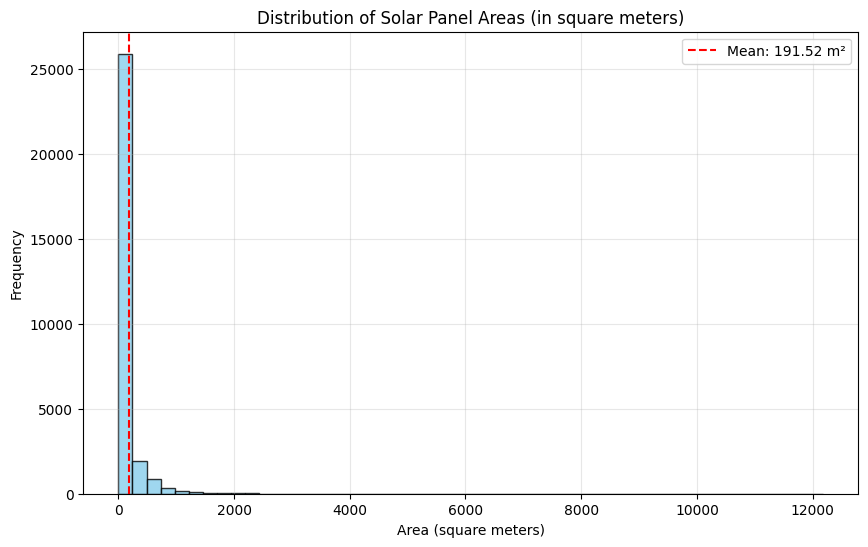


Observations from Histogram:
--------------------------------------------------
- The distribution peaks around 191.52 square meters.
- Spread is indicated by std dev of 630.70; higher values suggest variability.
- Check for skewness: right skew may indicate a few large panels, left skew small ones.
- Multiple peaks could suggest different panel sizes in the dataset.


In [6]:
PIXEL_SIZE = 0.31 

def calculate_area_from_line(line, img_width, img_height):
    parts = line.strip().split()
    if len(parts) != 5:
        return None  
    try:
        
        x_width_norm = float(parts[3])
        y_width_norm = float(parts[4])

        x_width_pixels = x_width_norm * img_width
        y_width_pixels = y_width_norm * img_height

        x_width_meters = x_width_pixels * PIXEL_SIZE
        y_width_meters = y_width_pixels * PIXEL_SIZE

        return x_width_meters * y_width_meters
    except (ValueError, IndexError):
        return None  

areas = []
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

sample_image_path = os.path.join(images_path, os.listdir(images_path)[0])
with Image.open(sample_image_path) as img:
    img_width, img_height = img.size
print(f"Using fixed image dimensions: {img_width}x{img_height} pixels")

for label_file in tqdm(label_files, desc="Calculating areas"):
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # Skip empty lines
                    area = calculate_area_from_line(line, img_width, img_height)
                    if area is not None:
                        areas.append(area)
    except Exception as e:
        print(f"Error processing {label_file}: {e}")

areas = np.array(areas)

total_instances = len(areas)
mean_area = np.mean(areas) if total_instances > 0 else 0
std_area = np.std(areas) if total_instances > 0 else 0
median_area = np.median(areas) if total_instances > 0 else 0
min_area = np.min(areas) if total_instances > 0 else 0
max_area = np.max(areas) if total_instances > 0 else 0

print("\nMethod Used to Compute Area:")
print("-" * 50)
print("For each solar panel instance:")
print("1. Extract normalized x_width and y_width from label file.")
print("2. Convert to pixels: width_pixels = normalized_width * image_width")
print(f"3. Convert to meters: width_meters = width_pixels * {PIXEL_SIZE}")
print("4. Area = x_width_meters * y_width_meters (in square meters)")

print("\nArea Statistics:")
print("-" * 50)
print(f"Total Instances: {total_instances}")
print(f"Mean Area: {mean_area:.2f} square meters")
print(f"Standard Deviation: {std_area:.2f} square meters")
print(f"Median Area: {median_area:.2f} square meters")
print(f"Minimum Area: {min_area:.2f} square meters")
print(f"Maximum Area: {max_area:.2f} square meters")

plt.figure(figsize=(10, 6))
plt.hist(areas, bins = 50, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Solar Panel Areas (in square meters)')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(mean_area, color='r', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_area:.2f} m²')
plt.legend()
plt.show()

print("\nObservations from Histogram:")
print("-" * 50)
if total_instances > 0:
    print(f"- The distribution peaks around {mean_area:.2f} square meters.")
    print(f"- Spread is indicated by std dev of {std_area:.2f}; higher values suggest variability.")
    print("- Check for skewness: right skew may indicate a few large panels, left skew small ones.")
    print("- Multiple peaks could suggest different panel sizes in the dataset.")
else:
    print("No valid areas calculated; check data integrity.")

# Implementing the Fundamental Functions


#### 1. Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 

In [7]:
boxA = [35, 51,196, 110]
boxB = [25, 60,180, 120]

xA = max(boxA[0], boxB[0])
yA = max(boxA[1], boxB[1])
xB = min(boxA[2], boxB[2])
yB = min(boxA[3], boxB[3])

print(xA,yA,xB,yB)

interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

iou = interArea / float(boxAArea + boxBArea - interArea)

print(iou)

35 60 180 110
0.6315521628498728


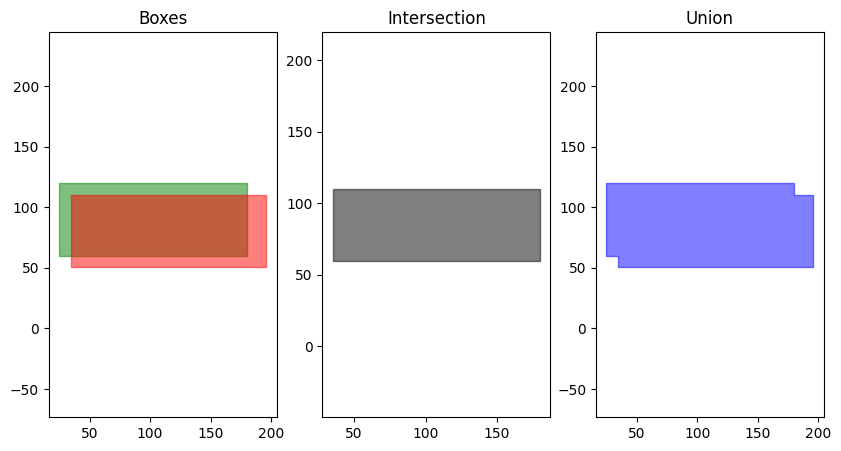

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import box

def plot_polygon(shapely_box, color='b'):
    if shapely_box is None or shapely_box.is_empty:
        return
    try:
        x, y = shapely_box.exterior.xy
        vertices = list(zip(x, y))
        poly = Polygon(vertices, closed=True, fill=True, color=color, alpha=0.5)
        plt.gca().add_patch(poly)
        plt.axis('equal')  # Equal aspect ratio
    except Exception as e:
        print(f"Error plotting polygon: {e}")

bA = box(35, 51, 196, 110)
bB = box(25, 60, 180, 120)

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.title("Boxes")
plot_polygon(bB, color='g')
plot_polygon(bA, color='r')

plt.subplot(1,3,2)
plt.title("Intersection")
interArea = bA.intersection(bB)
plot_polygon(interArea, color='k')

plt.subplot(1,3,3)
plt.title("Union")
union = bA.union(bB)
plot_polygon(union, color='b')

plt.show()

In [9]:
def compIou(bA,bB):
  return bA.intersection(bB).area / bA.union(bB).area

bA = box(35, 51,196, 110)
bB = box(25, 60,180, 120)

compIou(bA,bB)

0.62775997921898

In [10]:
bA = [[35, 51,196, 110]]
bB = [[25, 60,180, 120]]
bA = np.asarray(bA)
bB = np.asarray(bB)
sv.box_iou_batch(bA,bB)

array([[    0.62776]])

#### 2. Write a function to compute Average Precision (AP) 

In [11]:
def getPreRec(gx,gy,px,py):
    IOU=[]
    for i in range(0,10):
        bA = box(gx[i],gy[i],gx[i]+20,gy[i]+20)
        bB = box(px[i],py[i],px[i]+20,py[i]+20)
        iou = bA.intersection(bB).area / bA.union(bB).area
        IOU.append(iou)

    tpfp = ["TP" if score >=0.5 else "FP" for score in IOU]

    sc = 0
    accTP = []
    for i in range(0,10):
        if tpfp[i]=="TP":
            sc+=1
        accTP.append(sc)

    sc =0
    accFP = []
    for i in range(0,10):
        if tpfp[i]=="FP":
            sc+=1
        accFP.append(sc)

    groundTruths = 10
    precision = []
    recall = []

    for i in range(0,10):
        precision.append(accTP[i]/(accTP[i]+accFP[i]))
        recall.append(accTP[i]/groundTruths)

    return precision,recall

a. Use Pascal VOC 11 point interpolation method to implement the function 

In [12]:
def point11(precision,recall):
    su = 0
    r = np.linspace(0,1,11)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/11

b. Use COCO 101-point interpolation method to implement the function.

In [13]:
def point101(precision,recall):
    su = 0
    r = np.linspace(0,1,101)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/101     

c. Use Area under Precision-Recall Curve (AP) method to implement the function 

In [14]:
def AUC(precision,recall,length):
    s=0
    for i in range(1,length):
        width = recall[i]-recall[i-1]
        height = max(precision[i],precision[i-1])
        s += width*height
    return s

d.Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods.

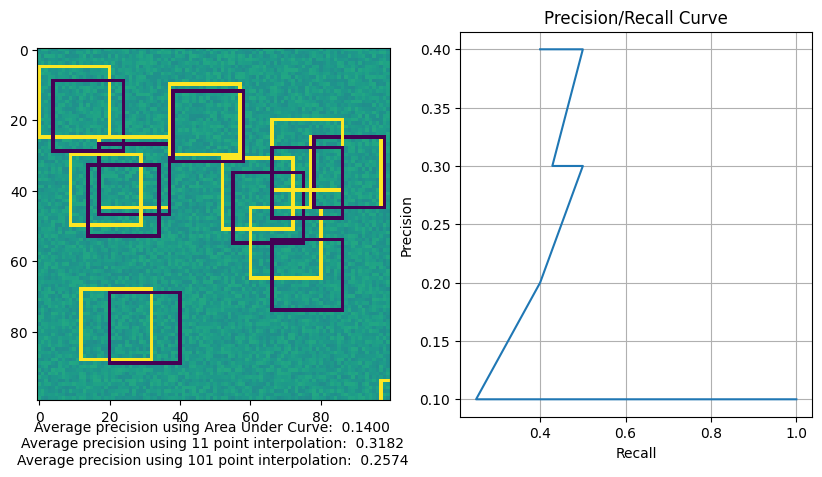

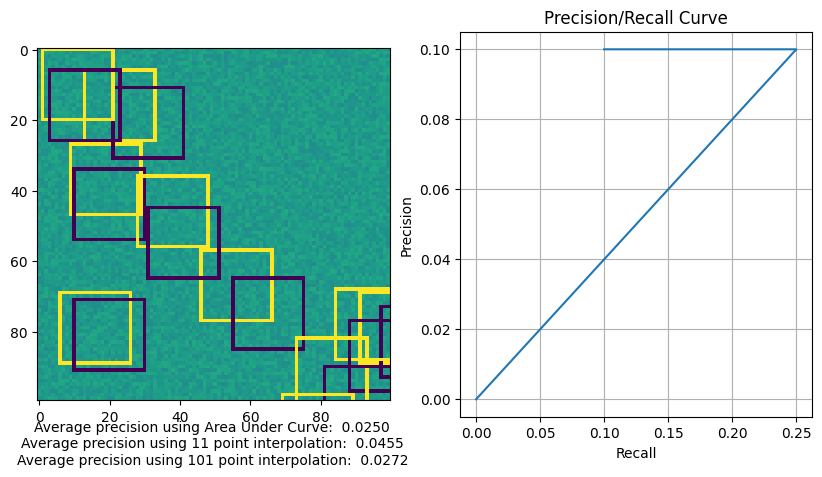

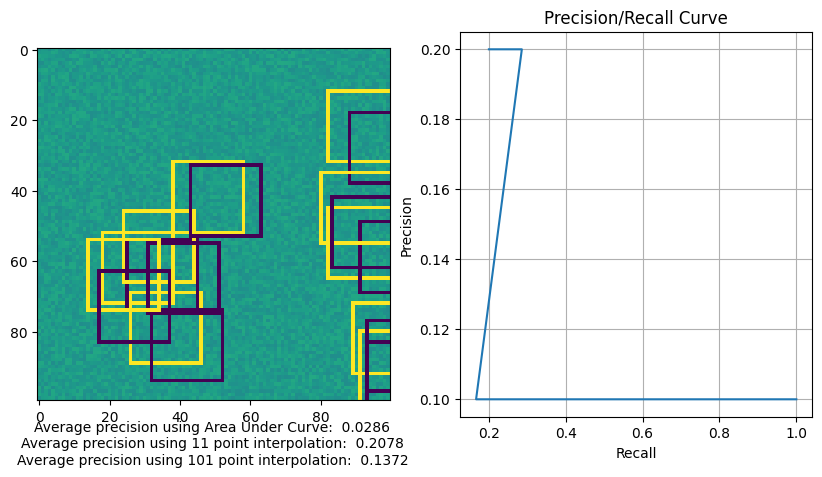

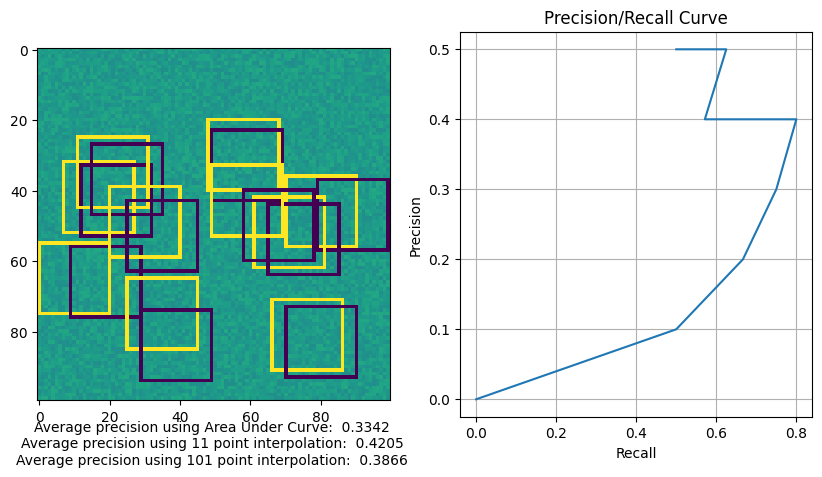

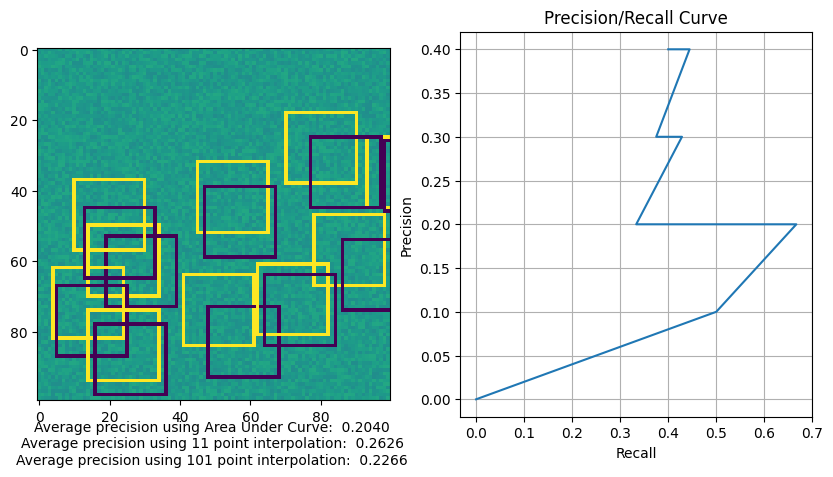

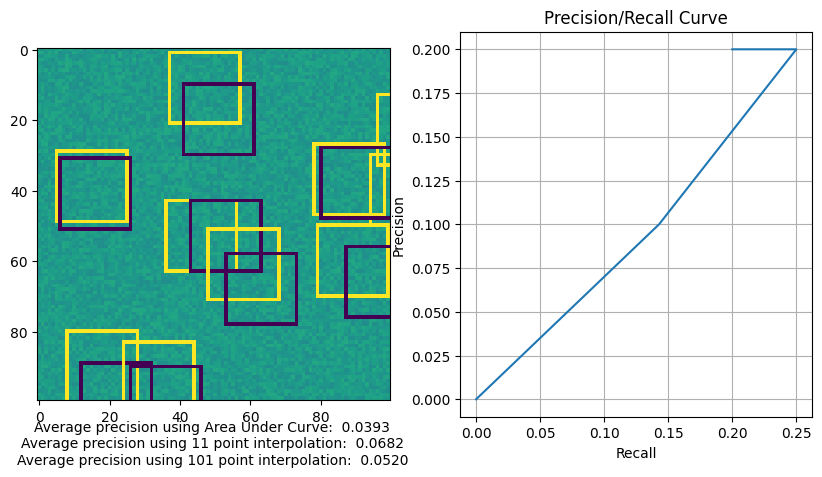

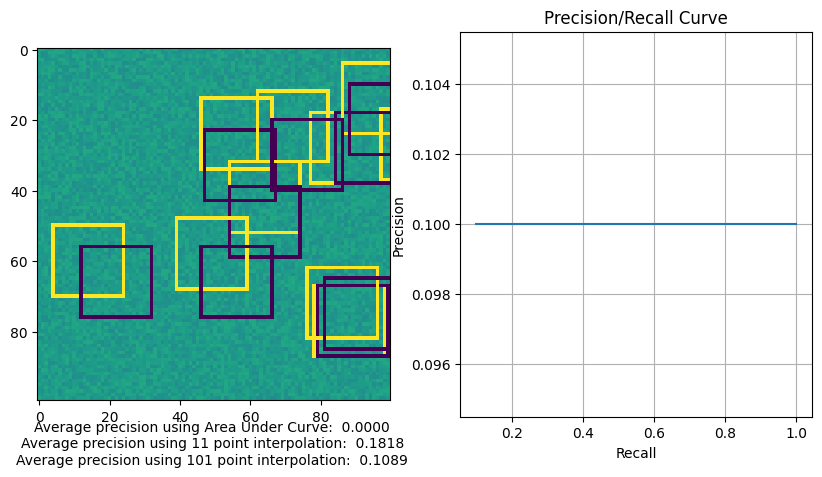

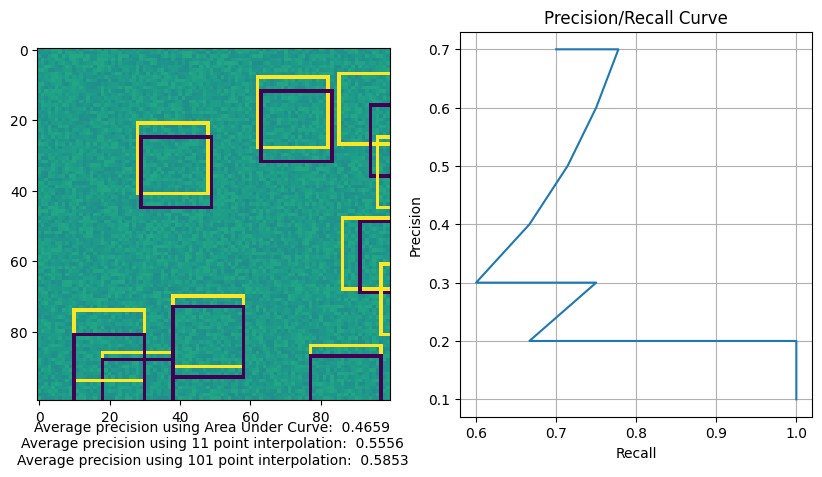

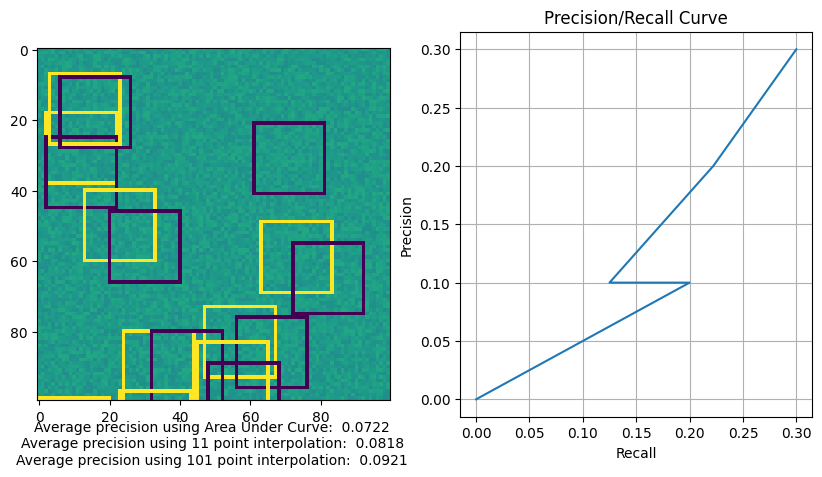

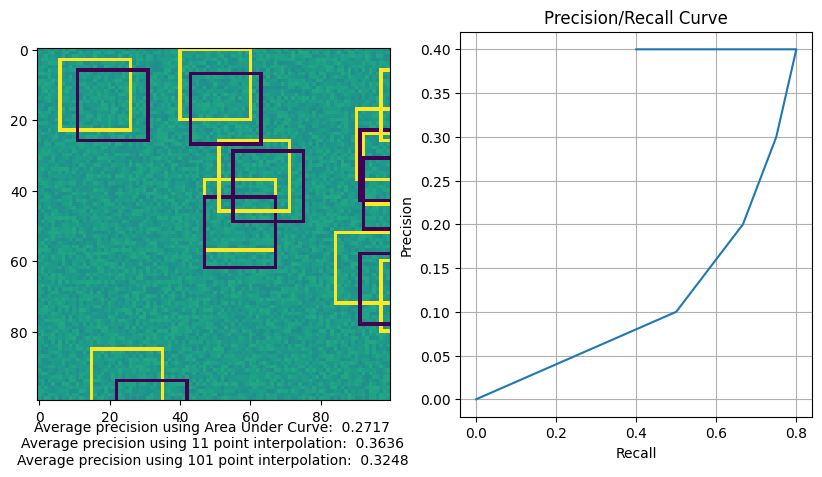

In [15]:
imgs = np.random.randint(125,155,size=(10,100,100)).astype(float)


for i in range(0,10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)


    gx = np.random.randint(0,100,size=(10))
    gy = np.random.randint(0,100,size=(10))

    px = np.random.randint(gx,gx+10,size=(10))
    py = np.random.randint(gy,gy+10,size=(10))

    precision,recall = getPreRec(gx,gy,px,py)



    for j in range(0,10):
        img = cv2.rectangle(imgs[i],(gx[j],gy[j]),(gx[j]+20,gy[j]+20),(255,0,0),1)
        img = cv2.rectangle(imgs[i],(px[j],py[j]),(px[j]+20,py[j]+20),(0,255,0),1)

    plt.imshow(img)

    plt.subplot(1,2,2)


    plt.plot(precision,recall)
    plt.grid()
    plt.title("Precision/Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.figtext(
        0.3, 0.02,
        f"Average precision using Area Under Curve:  {AUC(precision,recall,10):.4f}\nAverage precision using 11 point interpolation:  {point11(precision,recall):.4f}\nAverage precision using 101 point interpolation:  {point101(precision,recall):.4f}",
        wrap=True, horizontalalignment='center', fontsize=10 )

# Model building and evaluation 



#### 1.Split the data into 80-20 train-test split. Use 10% of training data as validation.
Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [16]:
import os

images_path = '/kaggle/working/srip_images'
labels_path = '/kaggle/working/srip_labels/labels_native'

if not os.path.isdir(images_path):
    print(f"Error: {images_path} is not a directory or does not exist.")
else:
    images_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]
    print(f"Number of files in {images_path}: {len(images_files)}")

if not os.path.isdir(labels_path):
    print(f"Error: {labels_path} is not a directory or does not exist.")
else:
    labels_files = [f for f in os.listdir(labels_path) if os.path.isfile(os.path.join(labels_path, f))]
    print(f"Number of files in {labels_path}: {len(labels_files)}")

Number of files in /kaggle/working/srip_images: 2542
Number of files in /kaggle/working/srip_labels/labels_native: 2542


In [17]:
!pip install pyyaml 
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml

images_path = '/kaggle/working/srip_images'
labels_path = '/kaggle/working/srip_labels/labels_native'

base_dir = '/kaggle/working/srip_dataset_split'
train_img_dir = os.path.join(base_dir, 'train', 'images')
train_lbl_dir = os.path.join(base_dir, 'train', 'labels')
val_img_dir   = os.path.join(base_dir, 'val', 'images')
val_lbl_dir   = os.path.join(base_dir, 'val', 'labels')
test_img_dir  = os.path.join(base_dir, 'test', 'images')
test_lbl_dir  = os.path.join(base_dir, 'test', 'labels')

for directory in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, test_img_dir, test_lbl_dir]:
    os.makedirs(directory, exist_ok=True)

if not os.path.exists(images_path):
    raise FileNotFoundError(f"Images directory not found: {images_path}")
if not os.path.exists(labels_path):
    raise FileNotFoundError(f"Labels directory not found: {labels_path}")

image_files = glob.glob(os.path.join(images_path, '*'))  # Adjust pattern if needed (e.g., '*.tif')
if not image_files:
    raise ValueError(f"No image files found in {images_path}")

train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

def copy_files(file_list, dest_img_dir, dest_lbl_dir):

    missing_labels = 0
    for file in tqdm(file_list, desc=f"Copying files to {dest_img_dir}"):
        shutil.copy(file, dest_img_dir)
        
        base_name = os.path.splitext(os.path.basename(file))[0]  # Remove extension
        label_file = os.path.join(labels_path, base_name + '.txt')
        if os.path.exists(label_file):
            shutil.copy(label_file, dest_lbl_dir)
        else:
            missing_labels += 1
            print(f"Warning: Label file not found for {file}")
    if missing_labels > 0:
        print(f"Total missing label files: {missing_labels}")

copy_files(train_files, train_img_dir, train_lbl_dir)
copy_files(val_files, val_img_dir, val_lbl_dir)
copy_files(test_files, test_img_dir, test_lbl_dir)

print("Dataset splitting and copying completed!")

data_yaml = {
    "train": train_img_dir,  # Path to training images
    "val": val_img_dir,      # Path to validation images
    "test": test_img_dir,    # Path to test images (optional for evaluation)
    "nc": 1,                 # Number of classes
    "names": ["solar_panel"] # List of class names
}

yaml_path = os.path.join(base_dir, "data.yaml")

with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("YAML configuration file created at:", yaml_path)

for split in ['train', 'val', 'test']:
    img_dir = os.path.join(base_dir, split, 'images')
    lbl_dir = os.path.join(base_dir, split, 'labels')
    print(f"{split} set: {len(os.listdir(img_dir))} images, {len(os.listdir(lbl_dir))} labels")

Copying files to /kaggle/working/srip_dataset_split/train/images: 100%|██████████| 1829/1829 [00:01<00:00, 1569.30it/s]
Copying files to /kaggle/working/srip_dataset_split/val/images: 100%|██████████| 204/204 [00:00<00:00, 1569.48it/s]
Copying files to /kaggle/working/srip_dataset_split/test/images: 100%|██████████| 509/509 [00:00<00:00, 1519.38it/s]

Dataset splitting and copying completed!
YAML configuration file created at: /kaggle/working/srip_dataset_split/data.yaml
train set: 1829 images, 1829 labels
val set: 204 images, 204 labels
test set: 509 images, 509 labels


In [18]:
import os

base_dir = '/kaggle/working/srip_dataset_split'
sets = ['train', 'val', 'test']

for set_name in sets:
    img_dir = os.path.join(base_dir, set_name, 'images')
    lbl_dir = os.path.join(base_dir, set_name, 'labels')
    
    if not os.path.isdir(img_dir):
        print(f"Error: {img_dir} is not a directory or does not exist.")
        num_images = 0
    else:
        images = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        num_images = len(images)
    
    if not os.path.isdir(lbl_dir):
        print(f"Error: {lbl_dir} is not a directory or does not exist.")
        num_labels = 0
    else:
        labels = [f for f in os.listdir(lbl_dir) if os.path.isfile(os.path.join(lbl_dir, f))]
        num_labels = len(labels)
    
    print(f"{set_name.capitalize()} set: {num_images} images, {num_labels} labels")
    
    if num_images != num_labels:
        print(f"Warning: Number of images ({num_images}) and labels ({num_labels}) do not match in {set_name} set.")

Train set: 1829 images, 1829 labels
Val set: 204 images, 204 labels
Test set: 509 images, 509 labels


In [20]:
!pip install ultralytics
from ultralytics import YOLO

model_run1 = YOLO("yolo11l.pt")
results_run1 = model_run1.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=30,
    imgsz=416,
    batch=16,
    lr0=0.01,
    project='/kaggle/working/srip_training/yolov11l',
    name='run1'
)

100%|██████████| 49.0M/49.0M [00:00<00:00, 239MB/s]


Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 17.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:01<00:00, 5.02MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/srip_dataset_split/train/labels... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:02<00:00, 718.84it/s]


train: New cache created: /kaggle/working/srip_dataset_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/srip_dataset_split/val/labels... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<00:00, 565.33it/s]

val: New cache created: /kaggle/working/srip_dataset_split/val/labels.cache


Plotting labels to /kaggle/working/srip_training/yolov11l/run1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.02G      1.711      1.406      1.313         53        416: 100%|██████████| 115/115 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


                   all        204       2457     0.0272        0.4     0.0175     0.0097

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.97G      1.591      1.083      1.215        120        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        204       2457      0.769      0.649      0.734      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.02G      1.476      1.019      1.184         55        416: 100%|██████████| 115/115 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        204       2457      0.679      0.543      0.609       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.97G      1.467     0.9798      1.172         43        416: 100%|██████████| 115/115 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        204       2457      0.713      0.673      0.721      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.95G      1.413     0.9453      1.141        149        416: 100%|██████████| 115/115 [00:41<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        204       2457      0.747      0.733      0.779      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.02G      1.382     0.9007      1.128        109        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        204       2457      0.762       0.74      0.792      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.92G      1.319     0.8444      1.095        141        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        204       2457      0.829       0.76      0.851      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         5G      1.268     0.7989      1.086         78        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        204       2457      0.859      0.806      0.865      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.97G      1.253      0.786      1.066         44        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        204       2457      0.861      0.834      0.885       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.04G      1.199     0.7643      1.052        103        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        204       2457      0.864      0.825      0.892      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.93G      1.186     0.7429      1.042         15        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        204       2457      0.875      0.818      0.899      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.97G       1.18     0.7316       1.03         49        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        204       2457      0.861      0.788      0.869      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.91G      1.151     0.7146      1.024         80        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        204       2457      0.887      0.837       0.91      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.03G      1.143     0.6987      1.022        169        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        204       2457      0.885       0.85      0.911      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.99G      1.103     0.6778      1.011         84        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        204       2457      0.912      0.831      0.913      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.03G      1.128     0.6835      1.004         40        416: 100%|██████████| 115/115 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        204       2457        0.9      0.867      0.926      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.97G      1.074     0.6392     0.9897         88        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        204       2457       0.91      0.853      0.928      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.99G      1.061     0.6357     0.9832         74        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        204       2457      0.927      0.872      0.938      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.94G      1.049     0.6257     0.9801        100        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        204       2457      0.925       0.88      0.941      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.02G      1.031     0.6162     0.9796         46        416: 100%|██████████| 115/115 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        204       2457      0.929       0.87      0.941      0.705


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.97G     0.9751     0.5694     0.9692         93        416: 100%|██████████| 115/115 [00:41<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        204       2457      0.917      0.878      0.939      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.01G      0.969     0.5618     0.9668        106        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        204       2457      0.924      0.879      0.942      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.96G     0.9438     0.5485     0.9574         39        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        204       2457      0.928      0.899      0.951       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         5G     0.9232     0.5315     0.9515         24        416: 100%|██████████| 115/115 [00:41<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        204       2457      0.922       0.92      0.955      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.98G     0.9083     0.5211      0.939         29        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        204       2457      0.939      0.893      0.951      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.01G     0.8887     0.5095     0.9365         60        416: 100%|██████████| 115/115 [00:41<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        204       2457      0.945      0.907      0.959      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.96G     0.8704     0.4904     0.9321         21        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        204       2457      0.944      0.918      0.961      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         5G     0.8536     0.4862     0.9195         25        416: 100%|██████████| 115/115 [00:41<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        204       2457      0.953      0.904      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.95G     0.8387     0.4729     0.9197         44        416: 100%|██████████| 115/115 [00:40<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        204       2457      0.956       0.91      0.962      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.02G     0.8116     0.4563      0.909         38        416: 100%|██████████| 115/115 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        204       2457      0.947      0.924      0.966      0.776



30 epochs completed in 0.381 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run1/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


                   all        204       2457      0.946      0.924      0.966      0.777


Speed: 0.1ms preprocess, 8.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run1


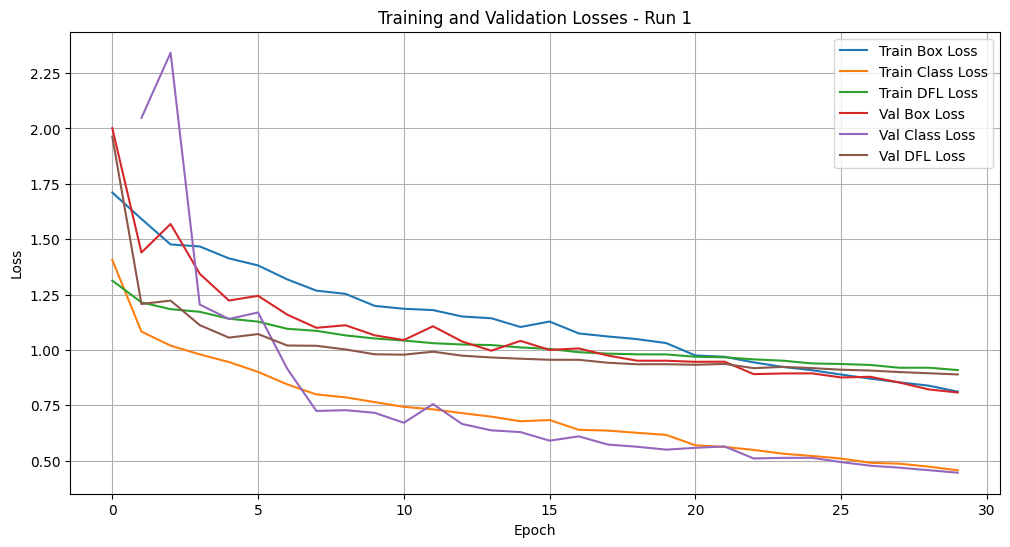

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/kaggle/working/srip_training/yolov11l/run1/results.csv'
results_df = pd.read_csv(results_path)

results_df.columns = results_df.columns.str.strip()

plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 1')
plt.legend()
plt.grid(True)
plt.show()

####  model 2

In [22]:
model_run2 = YOLO('yolo11l.pt')
results_run2 = model_run2.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=70,
    imgsz=416,
    batch=32,
    lr0=0.005,
    project='/kaggle/working/srip_training/yolov11l',
    name='run2'
)

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=70, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/srip_training/yolov11l/run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run2
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      9.54G      1.815      1.586      1.376        107        416: 100%|██████████| 58/58 [00:43<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        204       2457    0.00091     0.0179   0.000644   0.000228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      9.16G      1.578      1.071      1.231        153        416: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457     0.0392      0.171     0.0163    0.00748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      9.32G      1.488      1.011      1.207         89        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457     0.0315      0.301     0.0168     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      9.41G      1.483      1.001        1.2         38        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        204       2457      0.585      0.524      0.512      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      9.14G      1.393     0.9348      1.147         34        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        204       2457      0.727      0.726      0.754        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      9.15G      1.373     0.8845      1.135         50        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        204       2457      0.726      0.688      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      9.13G      1.313     0.8544      1.117         80        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        204       2457      0.855      0.768      0.854      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70       9.2G      1.294     0.8318       1.11         49        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        204       2457      0.781      0.779      0.816      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      9.25G      1.244     0.7846      1.077         95        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        204       2457      0.812      0.803      0.842      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      9.07G      1.246      0.783      1.067         93        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        204       2457      0.835      0.813      0.867      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      9.16G      1.258     0.7828      1.078        130        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        204       2457      0.826      0.792      0.846      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.07G      1.205     0.7481      1.058         73        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        204       2457      0.843      0.778      0.857      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      9.11G      1.182     0.7253      1.043         44        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457      0.823      0.801       0.87      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.41G      1.175     0.7251      1.036         85        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457      0.841      0.817      0.875      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      9.41G      1.143     0.7117      1.031         25        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.875      0.843      0.897      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.15G       1.13     0.6779       1.02        115        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        204       2457      0.873      0.814      0.887      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      9.08G      1.129     0.6909      1.021         38        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        204       2457      0.855      0.827      0.885      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      9.12G      1.129     0.6849      1.022         72        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.871      0.822      0.889      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70       9.2G      1.118     0.6705      1.006        122        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457       0.86      0.863      0.895      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.08G      1.086     0.6643      1.013         85        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.908      0.834       0.92      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70       9.5G      1.076     0.6483      1.005         44        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457       0.85      0.831      0.885      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.46G      1.051     0.6268          1         64        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457      0.868      0.814      0.885      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      9.12G      1.057     0.6272     0.9874         31        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457      0.857      0.847      0.899      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.22G      1.039     0.6239     0.9939         56        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

                   all        204       2457      0.904      0.858      0.924      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      9.16G       1.03     0.6124     0.9845         95        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        204       2457      0.915       0.84      0.923      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.19G       1.03     0.6148     0.9833        113        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.908      0.867      0.935      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.14G      1.004     0.5927      0.973         54        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.876      0.857      0.918      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70       9.3G      1.019     0.6079     0.9783         65        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.936      0.882      0.948      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      9.16G     0.9923     0.5924     0.9703         33        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        204       2457      0.902       0.87      0.925      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.08G      1.006     0.5851     0.9677        169        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.892      0.846      0.913      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      9.22G     0.9757     0.5717     0.9633         53        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.927      0.905      0.954      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.09G     0.9924      0.582     0.9709         85        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.933      0.903      0.957      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      9.22G     0.9571     0.5634     0.9622         68        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.921      0.895      0.952      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.15G     0.9329     0.5422     0.9479         58        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.929      0.901      0.955      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70       9.4G     0.9396     0.5506     0.9477        145        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.926       0.89      0.948      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.37G     0.9436     0.5463     0.9495        130        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        204       2457      0.925      0.879      0.947      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      9.21G     0.9262     0.5398     0.9577         18        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.946      0.902       0.96      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      9.24G     0.9303     0.5389     0.9451         83        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457       0.93      0.896      0.955      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      9.31G     0.9044     0.5247     0.9356         70        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.937      0.896      0.957      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.43G     0.8975     0.5253     0.9341         42        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.937      0.915      0.965       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      9.12G     0.8975     0.5256     0.9445         47        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.932       0.91       0.96      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      9.11G     0.9015     0.5223      0.939         28        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.936      0.897      0.955      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      9.16G     0.8771     0.5114      0.933        101        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457       0.93      0.917      0.963       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.43G      0.873     0.5069     0.9308         39        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.947      0.886      0.955      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.12G     0.8803     0.5075     0.9297        101        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.941      0.924      0.966      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.18G     0.8666     0.5056     0.9285        160        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.946      0.907      0.963      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      9.22G     0.8452     0.4913     0.9189         74        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.929      0.885      0.947      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      9.18G     0.8228     0.4787     0.9145         64        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457       0.94       0.92      0.962      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      9.22G     0.8369     0.4849     0.9211         79        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.952      0.926      0.972      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.18G     0.8115     0.4697     0.9097         58        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.946      0.935      0.974      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      9.09G     0.8313     0.4837     0.9175         57        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        204       2457      0.955      0.921      0.971      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.19G     0.8091     0.4738     0.9138         41        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.958      0.932      0.975      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70       9.2G       0.79     0.4624     0.9049         77        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.958      0.923      0.974      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      9.24G     0.8108     0.4706     0.9051         52        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        204       2457      0.956      0.931      0.974      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      9.11G      0.781     0.4542     0.9033         80        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.968      0.921      0.973      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      9.13G     0.7949     0.4627     0.9013         71        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457       0.95      0.937      0.974      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      9.12G     0.7744     0.4502     0.9012         40        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.954      0.929      0.973      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.08G     0.7771     0.4602     0.9012        207        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457       0.95      0.924      0.974        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70       9.1G     0.7584     0.4431     0.8945         98        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.955      0.921      0.972      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      9.24G     0.7342     0.4311     0.8933        106        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        204       2457      0.954      0.936      0.976      0.808


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      9.03G     0.6994     0.4019     0.8822         62        416: 100%|██████████| 58/58 [00:41<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        204       2457      0.968      0.934      0.979      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      8.92G      0.694     0.3988     0.8788         46        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.975      0.923      0.977      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      8.94G     0.6873     0.3927     0.8814         35        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.968      0.939      0.979       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      8.91G     0.6699     0.3845     0.8711         61        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.974      0.933      0.978      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      8.93G     0.6559     0.3804     0.8654         69        416: 100%|██████████| 58/58 [00:40<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.971      0.935      0.976      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      8.95G     0.6557     0.3796       0.87         28        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.971      0.942      0.979      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      9.01G     0.6509     0.3724     0.8655         48        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.954       0.95      0.978       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      8.96G     0.6417     0.3728     0.8646         33        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        204       2457      0.971      0.945       0.98      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      8.94G     0.6328     0.3658     0.8625         34        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        204       2457      0.965      0.945      0.979      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      8.95G     0.6208     0.3598     0.8576         37        416: 100%|██████████| 58/58 [00:40<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        204       2457      0.966      0.948       0.98      0.828



70 epochs completed in 0.875 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run2/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


                   all        204       2457      0.966      0.948       0.98      0.828


Speed: 0.1ms preprocess, 6.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run2


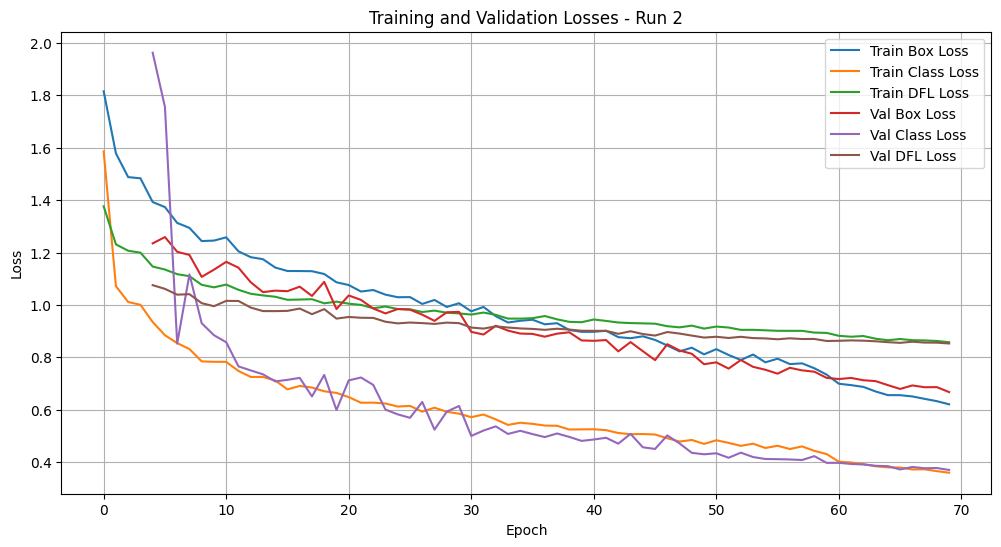

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/kaggle/working/srip_training/yolov11l/run2/results.csv'
results_df = pd.read_csv(results_path)

results_df.columns = results_df.columns.str.strip()

plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 2')
plt.legend()
plt.grid(True)
plt.show()

####  model 3

In [24]:
model_run3 = YOLO('yolo11l.pt')
results_run3 = model_run3.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=50,
    imgsz=416,
    batch=8,
    lr0=0.02,
    project='/kaggle/working/srip_training/yolov11l',
    name='run3'
)

Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1829 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1829/1829 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/srip_training/yolov11l/run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.85G      1.684       1.36      1.274         29        416: 100%|██████████| 229/229 [00:51<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        204       2457       0.71      0.658      0.651      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.54G        1.6      1.119      1.227         84        416: 100%|██████████| 229/229 [00:46<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]

                   all        204       2457      0.537      0.643      0.603      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.62G      1.554      1.105      1.217         56        416: 100%|██████████| 229/229 [00:46<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.09it/s]

                   all        204       2457        0.8      0.691      0.769      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.64G      1.527      1.066        1.2        160        416: 100%|██████████| 229/229 [00:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        204       2457      0.731      0.743      0.774      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.65G      1.446     0.9679      1.161         76        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.92it/s]

                   all        204       2457      0.715      0.679      0.731      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.58G      1.398     0.9454      1.137         36        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]

                   all        204       2457      0.744      0.682      0.698      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.63G      1.358     0.8851      1.129        117        416: 100%|██████████| 229/229 [00:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        204       2457      0.818      0.768      0.841      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.62G       1.34     0.8749      1.103         76        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        204       2457      0.857      0.801      0.876      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.64G      1.291      0.842      1.086         52        416: 100%|██████████| 229/229 [00:45<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        204       2457      0.844      0.793      0.871      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.58G      1.263     0.8124      1.077        112        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        204       2457      0.872      0.812      0.894      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.66G      1.258     0.8131      1.066         15        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        204       2457      0.881      0.824      0.893      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.63G      1.234     0.7673      1.061        105        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        204       2457      0.847      0.834      0.891      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.64G      1.212     0.7562      1.058         69        416: 100%|██████████| 229/229 [00:45<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        204       2457      0.869      0.818      0.893      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.58G      1.197     0.7475      1.041         89        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        204       2457      0.886      0.846      0.907      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.63G      1.168     0.7408       1.04        128        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        204       2457      0.865      0.825       0.89      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.63G      1.174      0.727       1.03         36        416: 100%|██████████| 229/229 [00:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        204       2457      0.885       0.86      0.915      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.63G      1.163     0.7136      1.021         95        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

                   all        204       2457      0.878      0.848      0.903      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.61G      1.156     0.7075      1.023         74        416: 100%|██████████| 229/229 [00:45<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.17it/s]

                   all        204       2457      0.885       0.86      0.924      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.66G      1.131     0.6908      1.019         64        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        204       2457       0.91      0.855       0.93      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.62G      1.107     0.6701      1.008         55        416: 100%|██████████| 229/229 [00:45<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        204       2457      0.864      0.843      0.904      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.63G      1.097     0.6734      1.002         55        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        204       2457      0.906      0.849      0.916      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.64G      1.076     0.6585     0.9994         32        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        204       2457      0.909      0.874      0.935      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.64G      1.091     0.6619     0.9985         40        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]

                   all        204       2457      0.915      0.873      0.934      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.65G      1.056     0.6359     0.9882        121        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

                   all        204       2457      0.922      0.875      0.939      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.64G      1.056     0.6335     0.9926         89        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        204       2457      0.917       0.87      0.937      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.61G      1.035     0.6323     0.9782         49        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        204       2457      0.921      0.894      0.945        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.63G      1.023     0.6149     0.9782         42        416: 100%|██████████| 229/229 [00:45<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        204       2457      0.919      0.879      0.942       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.62G      1.033      0.614     0.9741         87        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        204       2457      0.907      0.883      0.941      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.63G      1.016      0.605     0.9735         43        416: 100%|██████████| 229/229 [00:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        204       2457      0.929      0.892      0.948      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.58G      1.033     0.6096     0.9783        135        416: 100%|██████████| 229/229 [00:45<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        204       2457      0.918      0.884      0.941      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.64G      1.009     0.5922     0.9652         42        416: 100%|██████████| 229/229 [00:45<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        204       2457      0.928      0.892      0.947      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.62G          1     0.5909     0.9712         58        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        204       2457       0.94      0.898      0.955       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.61G     0.9794     0.5722     0.9586        132        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        204       2457      0.937      0.902      0.956      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.58G     0.9818     0.5836      0.966         48        416: 100%|██████████| 229/229 [00:45<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        204       2457      0.942      0.897      0.954      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.63G     0.9397     0.5534     0.9418        137        416: 100%|██████████| 229/229 [00:44<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.26it/s]

                   all        204       2457      0.935      0.906      0.957      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.63G     0.9362     0.5506     0.9469        119        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        204       2457      0.942      0.907      0.958      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.66G     0.9373     0.5426     0.9446         30        416: 100%|██████████| 229/229 [00:44<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

                   all        204       2457      0.938      0.915      0.962      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.58G     0.9221     0.5355     0.9366         61        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        204       2457      0.943      0.921      0.962      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.62G     0.9181     0.5266     0.9344         74        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        204       2457      0.943      0.909      0.957      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.62G     0.8826     0.5157     0.9323         48        416: 100%|██████████| 229/229 [00:44<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        204       2457      0.946      0.915      0.961      0.764


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.64G      0.856     0.4893     0.9208         60        416: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        204       2457      0.946      0.911      0.966      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.58G     0.8397     0.4821       0.92         29        416: 100%|██████████| 229/229 [00:44<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.21it/s]

                   all        204       2457      0.955      0.921      0.968      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.62G     0.8384     0.4722     0.9181         55        416: 100%|██████████| 229/229 [00:44<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]

                   all        204       2457       0.95      0.916      0.967      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.64G     0.8177     0.4682     0.9128         76        416: 100%|██████████| 229/229 [00:44<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        204       2457      0.954       0.93      0.972      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.62G     0.8068     0.4566     0.9107         30        416: 100%|██████████| 229/229 [00:45<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

                   all        204       2457      0.955      0.932       0.97      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.57G     0.7967     0.4497     0.9038        129        416: 100%|██████████| 229/229 [00:44<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        204       2457      0.949      0.933       0.97      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.66G      0.789     0.4476     0.8989         25        416: 100%|██████████| 229/229 [00:44<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        204       2457      0.959      0.926       0.97       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.62G     0.7727     0.4354     0.8977         70        416: 100%|██████████| 229/229 [00:44<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        204       2457      0.951      0.934      0.971      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.63G     0.7636      0.432     0.8955         27        416: 100%|██████████| 229/229 [00:44<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.18it/s]

                   all        204       2457      0.954      0.934      0.973      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.61G     0.7593     0.4335     0.8899        108        416: 100%|██████████| 229/229 [00:44<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]

                   all        204       2457      0.961      0.932      0.972      0.802



50 epochs completed in 0.686 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run3/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


                   all        204       2457      0.961      0.932      0.972      0.802


Speed: 0.1ms preprocess, 6.1ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run3


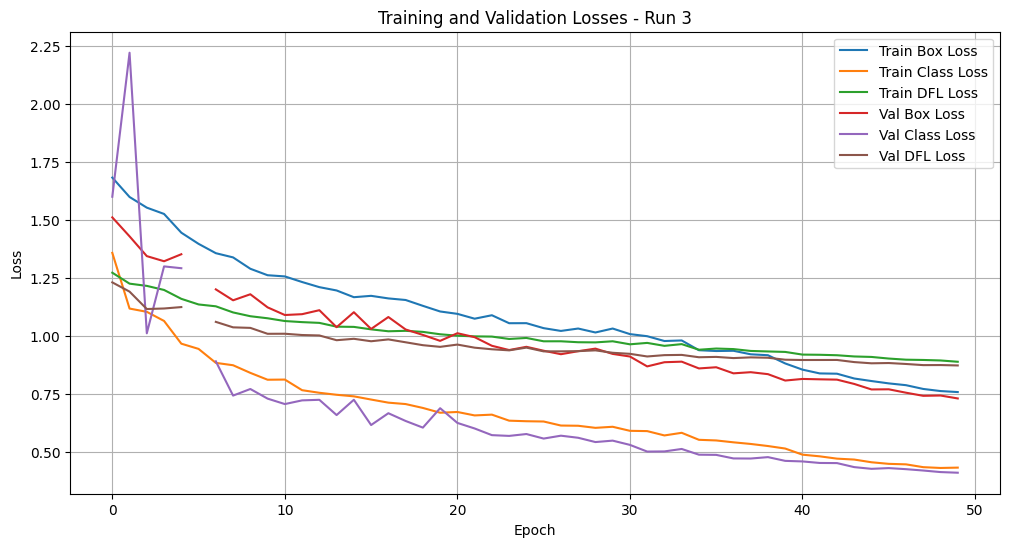

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/kaggle/working/srip_training/yolov11l/run3/results.csv'
results_df = pd.read_csv(results_path)

results_df.columns = results_df.columns.str.strip()

plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 3')
plt.legend()
plt.grid(True)
plt.show()

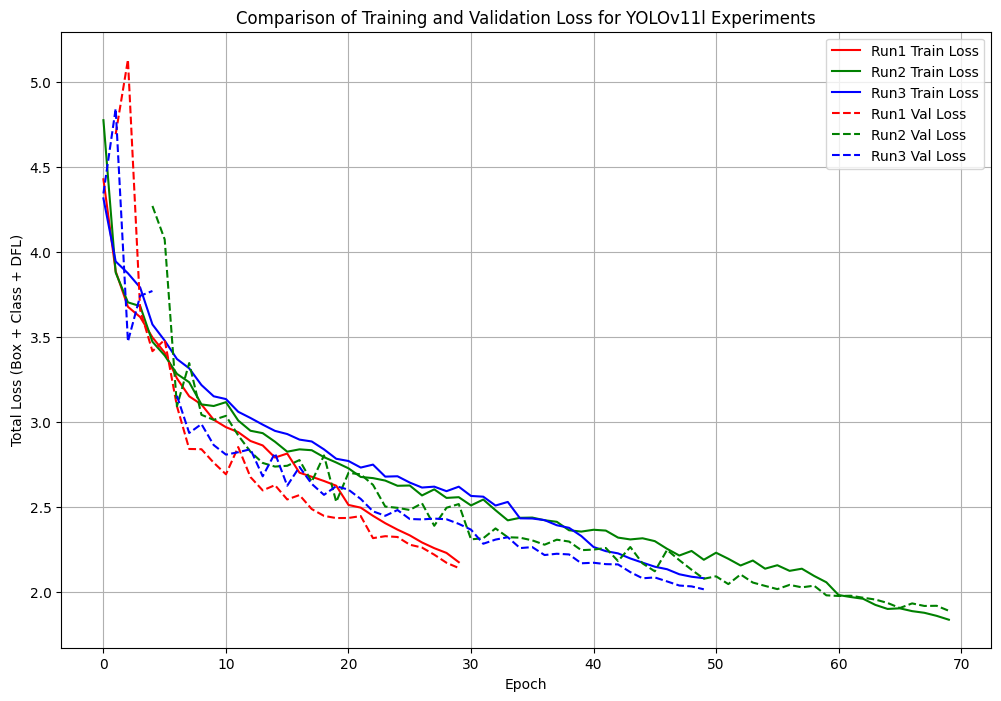

In [26]:
results_path1 = '/kaggle/working/srip_training/yolov11l/run1/results.csv'  # From your previous run1
results_path2 = '/kaggle/working/srip_training/yolov11l/run2/results.csv'
results_path3 = '/kaggle/working/srip_training/yolov11l/run3/results.csv'

history1 = pd.read_csv(results_path1)
history2 = pd.read_csv(results_path2)
history3 = pd.read_csv(results_path3)

history1.columns = history1.columns.str.strip()
history2.columns = history2.columns.str.strip()
history3.columns = history3.columns.str.strip()

plt.figure(figsize=(12, 8))

plt.plot(history1['train/box_loss'] + history1['train/cls_loss'] + history1['train/dfl_loss'], 
         label='Run1 Train Loss', color='red')
plt.plot(history2['train/box_loss'] + history2['train/cls_loss'] + history2['train/dfl_loss'], 
         label='Run2 Train Loss', color='green')
plt.plot(history3['train/box_loss'] + history3['train/cls_loss'] + history3['train/dfl_loss'], 
         label='Run3 Train Loss', color='blue')

plt.plot(history1['val/box_loss'] + history1['val/cls_loss'] + history1['val/dfl_loss'], 
         label='Run1 Val Loss', color='red', linestyle='dashed')
plt.plot(history2['val/box_loss'] + history2['val/cls_loss'] + history2['val/dfl_loss'], 
         label='Run2 Val Loss', color='green', linestyle='dashed')
plt.plot(history3['val/box_loss'] + history3['val/cls_loss'] + history3['val/dfl_loss'], 
         label='Run3 Val Loss', color='blue', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Total Loss (Box + Class + DFL)')
plt.title('Comparison of Training and Validation Loss for YOLOv11l Experiments')
plt.legend()
plt.grid(True)
plt.show()

#### 2.Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_1055_y0_9105_dxdy_416.tif: 416x416 3 solar_panels, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_8660_y0_4032_dxdy_416.tif: 416x416 17 solar_panels, 27.9ms
Speed: 0.7ms preprocess, 27.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_1__x0_5989_y0_12270_dxdy_416.tif: 416x416 7 solar_panels, 27.9ms
Speed: 0.8ms preprocess, 27.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_2562_y0_5007_dxdy_416.tif: 416x416 19 solar_panels, 24.1ms
Speed: 0.8ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/srip_dataset_split

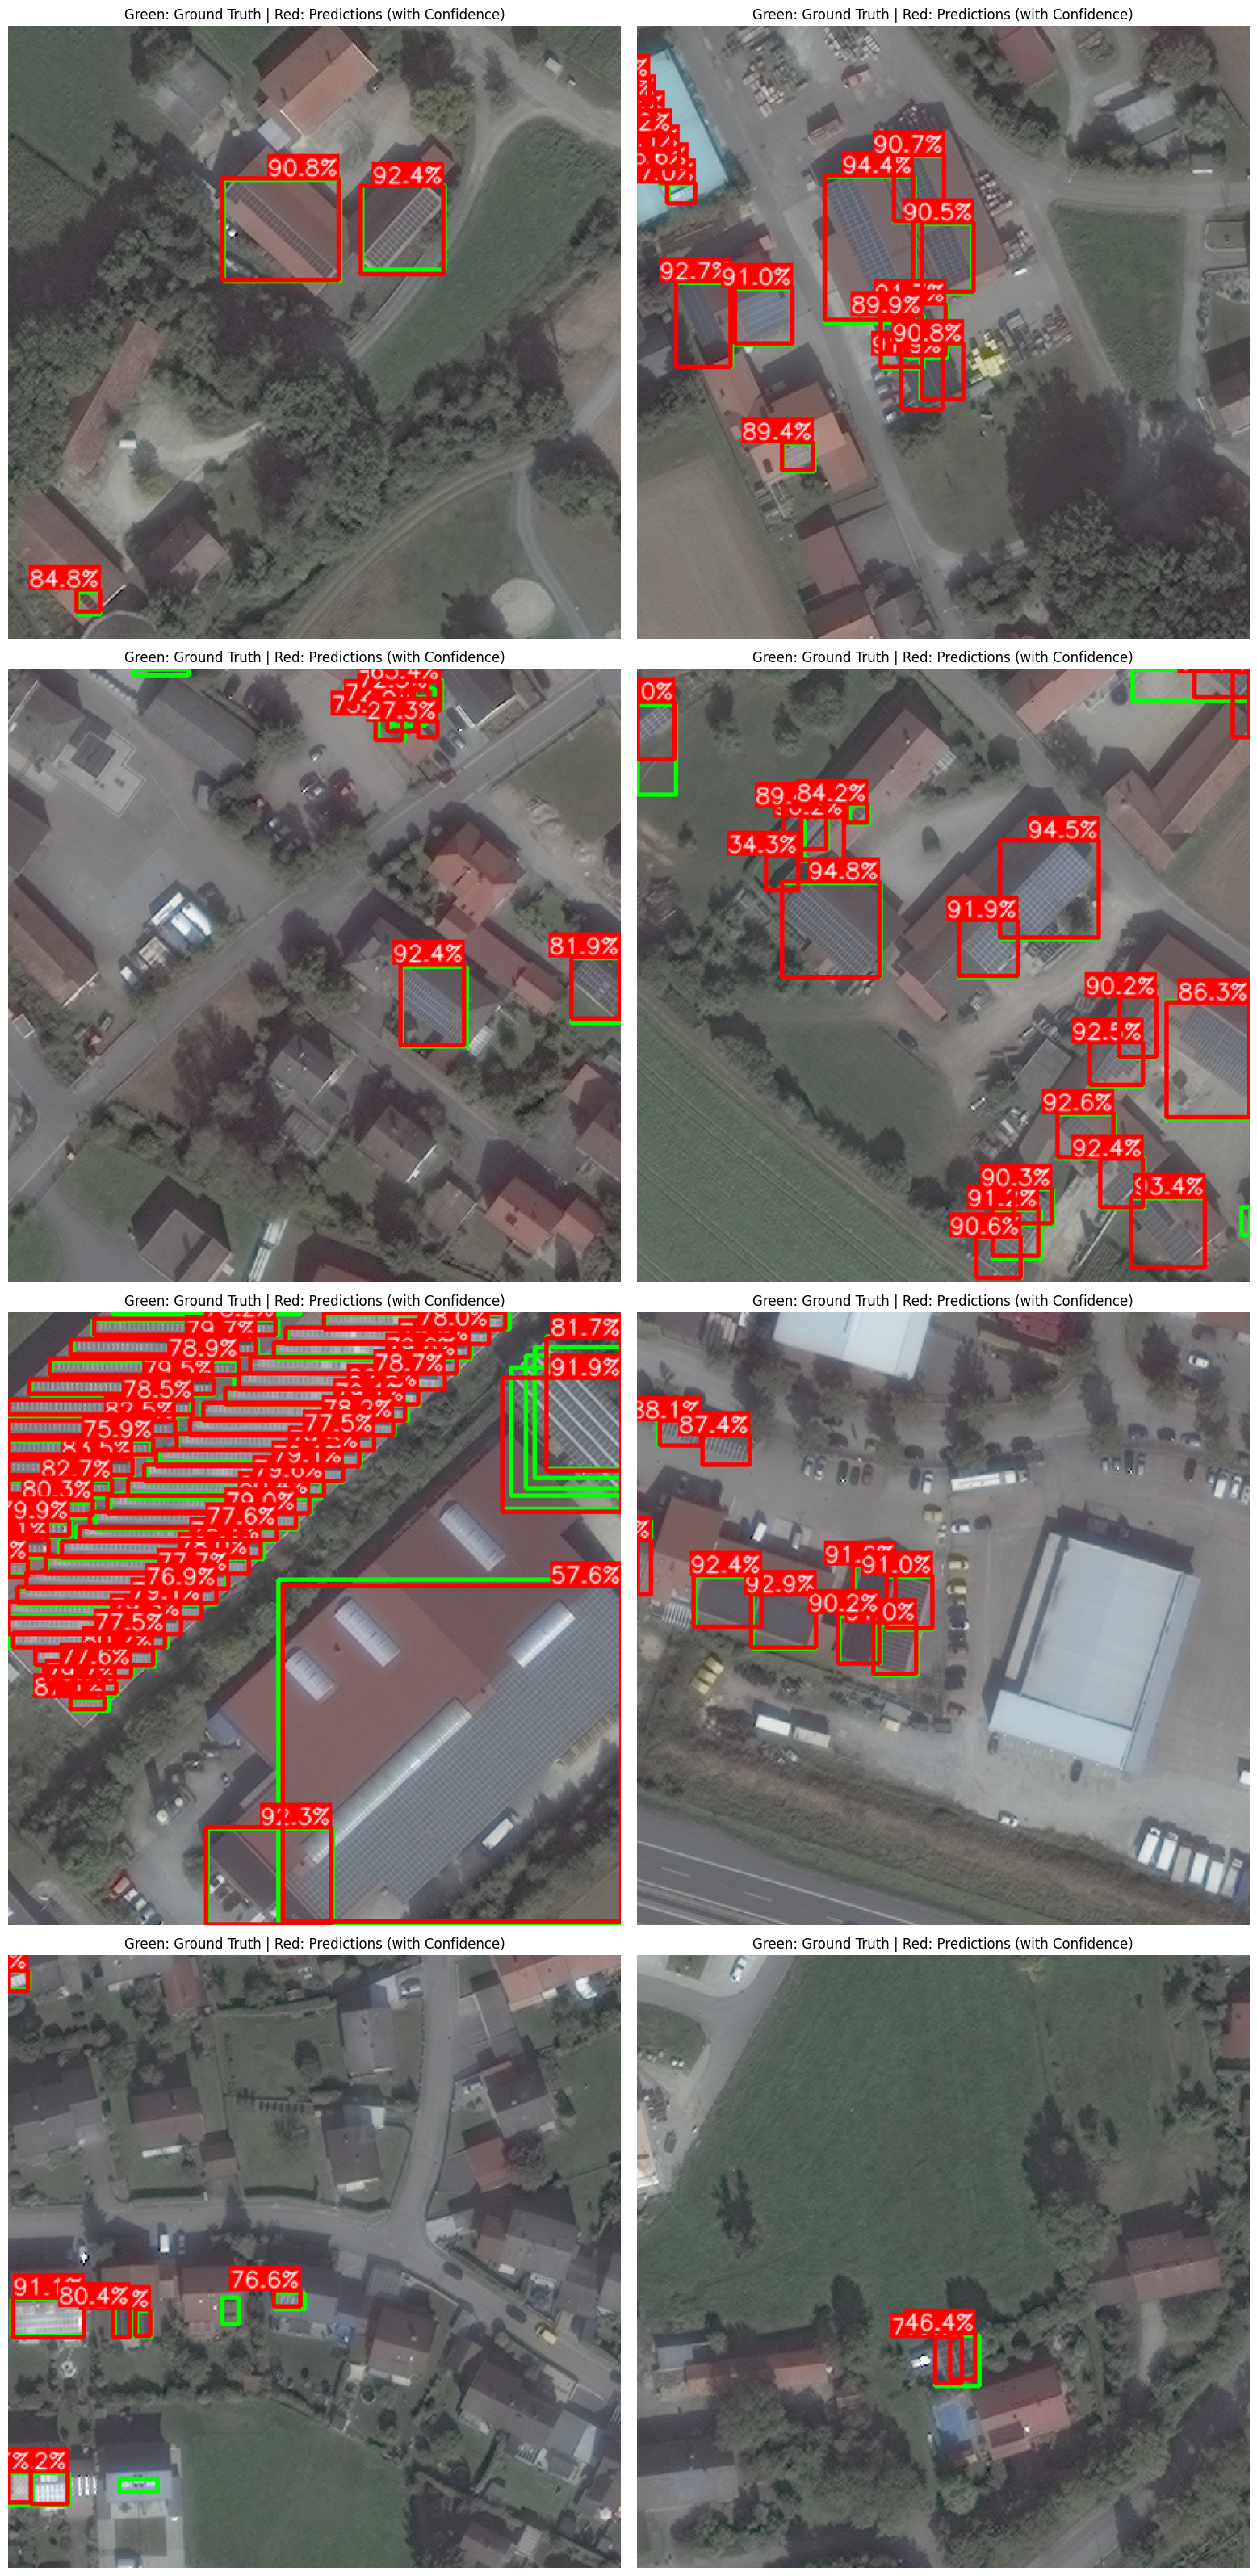

In [27]:
import os
import cv2
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

def load_gt_boxes(label_path, img_width=416, img_height=416):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_min = int((x_center - w_norm/2) * img_width)
            y_min = int((y_center - h_norm/2) * img_height)
            x_max = int((x_center + w_norm/2) * img_width)
            y_max = int((y_center + h_norm/2) * img_height)
            boxes.append([x_min, y_min, x_max, y_max])
    return boxes

test_img_dir = '/kaggle/working/srip_dataset_split/test/images'
test_lbl_dir = '/kaggle/working/srip_dataset_split/test/labels'

test_images = glob.glob(os.path.join(test_img_dir, '*'))
sample_images = random.sample(test_images, 8)

model_path = '/kaggle/working/srip_training/yolov11l/run2/weights/last.pt'
model = YOLO(model_path)

fig, axes = plt.subplots(4, 2, figsize=(16, 32))  # 4 rows, 2 columns, adjusted figure size
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    base_name = os.path.basename(img_path)
    label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
    gt_boxes = load_gt_boxes(label_file, img_width=416, img_height=416)
    
    results = model.predict(source=img_path, conf=0.25, iou=0.5)
    pred_boxes = []
    pred_scores = []
    
    if results:
        for box in results[0].boxes.xyxy.cpu().numpy():
            pred_boxes.append(box.tolist())
        for score in results[0].boxes.conf.cpu().numpy():
            pred_scores.append(score)
    
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    for box, score in zip(pred_boxes, pred_scores):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        text = f"{score*100:.1f}%"
        ((text_width, text_height), _) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_rgb, (x_max - text_width, y_min), (x_max, y_min - text_height - 4), (255, 0, 0), -1)
        cv2.putText(img_rgb, text, (x_max - text_width, y_min - 2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title("Green: Ground Truth | Red: Predictions (with Confidence)")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

#### 3.Use supervision.metrics functionality from supervision library to compute the following metrics.


a.Compute mAP50 with supervision and compare with your implementation. What do you observe ?

b.Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 

In [58]:
!pip install tabulate

In [60]:
import os
import pandas as pd
import numpy as np
from ultralytics import YOLO
import supervision as sv

def AUC(precision, recall, length):
    s = 0
    for i in range(1, length):
        width = recall[i] - recall[i-1]
        height = max(precision[i], precision[i-1])
        s += width * height
    return s

def point11(precision, recall):
    su = 0
    r_points = np.linspace(0, 1, 11)
    for r in r_points:
        valid = [p for p, rec in zip(precision, recall) if rec >= r]
        su += max(valid) if valid else 0
    return su / 11

def point101(precision, recall):
    su = 0
    r_points = np.linspace(0, 1, 101)
    for r in r_points:
        valid = [p for p, rec in zip(precision, recall) if rec >= r]
        su += max(valid) if valid else 0
    return su / 101

images_path = "/kaggle/working/srip_dataset_split/test/images"
labels_path = "/kaggle/working/srip_dataset_split/test/labels"

model = YOLO("/kaggle/working/srip_training/yolov11l/run2/weights/best.pt")

ground_truths = []
detections_list = []

for img in os.listdir(images_path):
    label_file = os.path.join(labels_path, img.split('.')[0] + '.txt')
    txt = pd.read_csv(label_file, sep=" ", header=None)
    txt.columns = ['category', 'xc', 'yc', 'xw', 'yw']
    
    conf = []
    clss = []
    box = []
    
    for ind, row in txt.iterrows():
        xc = int(row.xc * 416 - row.xw * 416 / 2)
        yc = int(row.yc * 416 - row.yw * 416 / 2)
        x_max = int(xc + row.xw * 416)
        y_max = int(yc + row.yw * 416)
        b = [xc, yc, x_max, y_max]
        box.append(b)
        conf.append(1.0)
        clss.append(0)  # all labels are assumed to be class 0 (solar panel)
    
    box = np.asarray(box)
    conf = np.asarray(conf)
    clss = np.asarray(clss)
    
    ground_truth = sv.Detections(
        xyxy=box,
        confidence=conf,
        class_id=clss
    )
    ground_truths.append(ground_truth)
    
    results = model(os.path.join(images_path, img), verbose=False)
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        confidence = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        
        detections = sv.Detections(
            xyxy=boxes,
            confidence=confidence,
            class_id=class_ids
        )
        detections_list.append(detections)

mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=detections_list,
    targets=ground_truths,
)
print("mAP50 using supervision: {:.4f}".format(mean_average_precision.map50))

confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=detections_list,
    targets=ground_truths,
    classes=['solar panel']
)
print("Confusion Matrix:")
print(confusion_matrix.matrix)

mAPAUC = []
mAP101 = []
mAP11 = []

for i in range(len(detections_list)):
    prec = []
    rec = []
    cm = sv.ConfusionMatrix.from_detections(
        predictions=[detections_list[i]],
        targets=[ground_truths[i]],
        classes=['solar panel'],
        iou_threshold=0.5
    )
    TP = cm.matrix[0][0]
    FP = cm.matrix[1][0]
    FN = cm.matrix[0][1]
    p = TP / (TP + FP) if (TP + FP) > 0 else 0
    r = TP / (TP + FN) if (TP + FN) > 0 else 0
    prec.append(p)
    rec.append(r)
    
    mAPAUC.append(AUC(prec, rec, len(prec)))
    mAP101.append(point101(prec, rec))
    mAP11.append(point11(prec, rec))

mAPAUC = np.asarray(mAPAUC)
mAP101 = np.asarray(mAP101)
mAP11 = np.asarray(mAP11)

mAP11[np.isnan(mAP11)] = 0
print("11 point: ", mAP11.mean())
mAP101[np.isnan(mAP101)] = 0
print("101 point: ", mAP101.mean())
mAPAUC[np.isnan(mAPAUC)] = 0
print("AUC: ", mAPAUC.mean())

precision_vals = []
recall_vals = []
f1_vals = []

for iou_thresh in [0.1, 0.3, 0.5, 0.7, 0.9]:
    pre_list = []
    rec_list = []
    f1_list = []
    for conf_thresh in [0.1, 0.3, 0.5, 0.7, 0.9]:
        cm = sv.ConfusionMatrix.from_detections(
            predictions=detections_list,
            targets=ground_truths,
            classes=['solar panel'],
            conf_threshold=conf_thresh,
            iou_threshold=iou_thresh,
        )
        TP = cm.matrix[0][0]
        FP = cm.matrix[1][0]
        FN = cm.matrix[0][1]
        p = TP / (TP + FP) if (TP + FP) > 0 else 0
        r = TP / (TP + FN) if (TP + FN) > 0 else 0
        f = (2 * p * r / (p + r)) if (p + r) > 0 else 0
        
        pre_list.append(p)
        rec_list.append(r)
        f1_list.append(f)
    
    precision_vals.append(pre_list)
    recall_vals.append(rec_list)
    f1_vals.append(f1_list)

precision_df = pd.DataFrame(precision_vals, index=[0.1, 0.3, 0.5, 0.7, 0.9], columns=[0.1, 0.3, 0.5, 0.7, 0.9])


recall_df = pd.DataFrame(recall_vals, index=[0.1, 0.3, 0.5, 0.7, 0.9], columns=[0.1, 0.3, 0.5, 0.7, 0.9])


f1_df = pd.DataFrame(f1_vals, index=[0.1, 0.3, 0.5, 0.7, 0.9], columns=[0.1, 0.3, 0.5, 0.7, 0.9])


from tabulate import tabulate

def print_table(df, title):
    print(f"\n{title}")
    print(tabulate(df, headers="keys", tablefmt="grid", floatfmt=".4f"))

print_table(precision_df, "Precision Table")
print_table(recall_df, "Recall Table")
print_table(f1_df, "F1 Score Table")


mAP50 using supervision: 0.9747
Confusion Matrix:
[[       5744         258]
 [        420           0]]
11 point:  0.8480370281897532
101 point:  0.8552027883430808
AUC:  0.0

Precision Table
+--------+--------+--------+--------+--------+--------+
|        |    0.1 |    0.3 |    0.5 |    0.7 |    0.9 |
+========+========+========+========+========+========+
| 0.1000 | 0.9276 | 0.9369 | 0.9690 | 0.9918 | 1.0000 |
+--------+--------+--------+--------+--------+--------+
| 0.3000 | 0.9270 | 0.9364 | 0.9688 | 0.9917 | 1.0000 |
+--------+--------+--------+--------+--------+--------+
| 0.5000 | 0.9225 | 0.9319 | 0.9645 | 0.9893 | 0.9995 |
+--------+--------+--------+--------+--------+--------+
| 0.7000 | 0.8750 | 0.8853 | 0.9210 | 0.9565 | 0.9990 |
+--------+--------+--------+--------+--------+--------+
| 0.9000 | 0.4369 | 0.4429 | 0.4655 | 0.4977 | 0.8754 |
+--------+--------+--------+--------+--------+--------+

Recall Table
+--------+--------+--------+--------+--------+--------+
|        